In [1]:
# %load TwoFundamFactors_mod.py
"""
Two Fundamental Factors
"""

#%matplotlib inline
import numpy as np
from scipy.io import loadmat
import pandas as pd
import functions as fn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.metrics import mean_squared_error

sns.set(style='darkgrid')
#pd.set_option('display.max_rows', 16)

matP = loadmat('inputData_SPX_200401_201312Select.mat', variable_names=['tday', 'syms', 'bid', 'ask'])
mat1 = loadmat('fundamentalDataSelect.mat', variable_names=['tday', 'syms', 'ARQ_PB'])
mat2 = loadmat('fundamentalsSelect.mat', variable_names=["ARQ_EPS","ARQ_BVPS"])

symsP = [e[0] for e in matP.pop('syms').squeeze()]
syms1 = [e[0] for e in mat1.pop('syms').squeeze()]

dates1 = pd.DatetimeIndex(mat1.pop('tday').astype(str).squeeze())
datesP = pd.DatetimeIndex(matP.pop('tday').astype(str).squeeze())

assert(symsP==syms1)
assert(all(dates1==datesP))

mid = pd.DataFrame((matP['bid'] + matP['ask']) / 2)

Ret1 = fn.calculateReturns(mid.copy(), 1)

# hold for 21 days (1 month)
holdingDays = 21

# monthly return
RetM = fn.calculateReturns(mid.copy(), holdingDays)
del matP

# shifted next quarter's return to today's row to use as response variable.
# Can enter only at next day's close.
RetFut = RetM.copy().shift(-(holdingDays+1))

del RetM, mid

#############################
m = RetFut.shape[0]
trainSize = m // 2
testSize = m - trainSize
#############################

RetFutTrain = RetFut.iloc[:trainSize]
RetFutTest = RetFut.iloc[trainSize:]
Ret1train = Ret1.iloc[:trainSize]
Ret1test = Ret1.iloc[trainSize:]

#flattening and repetition of the date vector
flat_train = RetFutTrain.size
flat_test = RetFutTest.size
m0 = RetFut.shape[0] #original number of observations
nStocks = len(syms1) #original number of stocks

datesTrain = dates1.to_numpy()[:trainSize].flatten()
datesTest = dates1.to_numpy()[trainSize:].flatten()

del dates1, datesP, RetFut

# Combine different independent variables into one matrix X for training
Xtrain = np.nan * np.empty((trainSize * len(symsP), 2))
Xtest = np.nan * np.empty((testSize * len(symsP), 2))

# dependent variable
Ytrain = RetFutTrain.to_numpy().flatten()[:,np.newaxis]
Ytest = RetFutTest.to_numpy().flatten()[:,np.newaxis]

# Earnings (net income) per Basic Share
earningsInc = pd.DataFrame(mat2.pop('ARQ_EPS'))
bvpershr = pd.DataFrame(mat2.pop('ARQ_BVPS'))

bvpershr_lag = bvpershr.ffill().shift(1)

del mat2

ROE = 1 + earningsInc.divide(bvpershr_lag)
ROE.fillna(value=-99.5, inplace=True)
ROE[ROE <= 0] = np.nan

BM = 1 / pd.DataFrame(mat1.pop('ARQ_PB'))
BM.fillna(value=-99.5, inplace=True)
BM[BM <= 0] = np.nan

del mat1

Xtrain[:,0] = np.log(BM.iloc[:trainSize].to_numpy()).flatten()
Xtrain[:,1] = np.log(ROE.iloc[:trainSize].to_numpy()).flatten()

Xtest[:,0] = np.log(BM.iloc[trainSize:].to_numpy()).flatten()
Xtest[:,1] = np.log(ROE.iloc[trainSize:].to_numpy()).flatten()

XYtrain = pd.DataFrame(np.hstack([Xtrain, Ytrain])).dropna(how='any', axis=0)
XYtest = pd.DataFrame(np.hstack([Xtest, Ytest])).dropna(how='any', axis=0)

ixCleanTrain = XYtrain.index.to_numpy()
ixCleanTest = XYtest.index.to_numpy()

XYtrain = XYtrain.to_numpy()
XYtest = XYtest.to_numpy()

Xtrain, ytrain = XYtrain[:, 0:-1], XYtrain[:, -1][:,np.newaxis]
Xtest, ytest = XYtest[:, 0:-1], XYtest[:, -1][:,np.newaxis]

In [10]:
n_estimators = [100, 150, 200, 250, 300, 350, 400, 450, 500]
train_results = []
test_results = []
for estimator in n_estimators:
    rfcModel = RandomForestRegressor(max_depth=5, n_estimators=estimator, random_state=42).fit(Xtrain, ytrain.flatten())
    Ypred = rfcModel.predict(Xtrain)
    
    retPred = np.nan * np.empty((flat_train, ))
    retPred[ixCleanTrain] = Ypred
    retPred = retPred.reshape(RetFutTrain.shape)

    def compare_nan_array(func, a, thresh):
        out = ~np.isnan(a)
        out[out] = func(a[out] , thresh)
        return out

    longs = pd.DataFrame(compare_nan_array(np.greater, retPred, 0).astype(int)).shift(1) #1 day later
    shorts = pd.DataFrame(compare_nan_array(np.less, retPred, 0).astype(int)).shift(1)

    longs.iloc[0] = 0
    shorts.iloc[0] = 0

    positions = np.zeros(retPred.shape)

    for h in range(holdingDays):
        long_lag = longs.shift(h)
        long_lag.fillna(value=0, inplace=True)
        long_lag = long_lag.to_numpy(dtype=bool)

        short_lag = shorts.shift(h)
        short_lag.fillna(value=0, inplace=True)
        short_lag = short_lag.to_numpy(dtype=bool)

        positions[long_lag] += 1
        positions[short_lag] -= 1

    dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1train.fillna(0).to_numpy()), axis=1)
    dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

    dailyRet = np.divide(dRetA, dRetB, out=np.zeros_like(dRetA), where=dRetB!=0)
    dailyRet[~np.isfinite(dailyRet)] = 0
    cumret = np.cumprod(1 + dailyRet) - 1


    cagr = (1 + cumret[-1]) ** (252 / trainSize) - 1
    train_results.append(cagr)
    maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
    ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
    print('n_estimator=',estimator,'\n',('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

    ##################################################################

    # Make real predictions on test (out-of-sample)
    Ypred = rfcModel.predict(Xtest)

    # print(('Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytest, Ypred))))

    retPred = np.nan * np.empty((RetFutTest.size, ))
    retPred[ixCleanTest] = Ypred
    retPred = retPred.reshape(RetFutTest.shape)

    longs = pd.DataFrame(compare_nan_array(np.greater, retPred, 0).astype(int)).shift(1) #1 day later
    shorts = pd.DataFrame(compare_nan_array(np.less, retPred, 0).astype(int)).shift(1)

    longs.iloc[0] = 0
    shorts.iloc[0] = 0

    positions = np.zeros(retPred.shape)

    for h in range(holdingDays):
        long_lag = longs.shift(h)
        long_lag.fillna(value=0, inplace=True)
        long_lag = long_lag.to_numpy(dtype=bool)

        short_lag = shorts.shift(h)
        short_lag.fillna(value=0, inplace=True)
        short_lag = short_lag.to_numpy(dtype=bool)

        positions[long_lag] += 1
        positions[short_lag] -= 1

    dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1test.fillna(0).to_numpy()), axis=1)
    dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

    dailyRet = np.divide(dRetA, dRetB, out=np.zeros_like(dRetA), where=dRetB!=0)
    dailyRet[~np.isfinite(dailyRet)] = 0
    cumret = np.cumprod(1 + dailyRet) - 1

    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()

    cagr = (1 + cumret[-1]) ** (252 / testSize) - 1
    test_results.append(cagr)
    maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
    ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
    print(('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

n_estimator= 100 
 In-sample: CAGR=0.047689 Sharpe ratio=0.306808 maxDD=-0.461864 maxDDD=547 Calmar ratio=0.103253
Out-of-sample: CAGR=0.236748 Sharpe ratio=1.36911 maxDD=-0.200744 maxDDD=145 Calmar ratio=1.17936
n_estimator= 150 
 In-sample: CAGR=0.057564 Sharpe ratio=0.343231 maxDD=-0.434303 maxDDD=533 Calmar ratio=0.132544
Out-of-sample: CAGR=0.235461 Sharpe ratio=1.36374 maxDD=-0.202216 maxDDD=173 Calmar ratio=1.1644
n_estimator= 200 
 In-sample: CAGR=0.0707828 Sharpe ratio=0.388298 maxDD=-0.436139 maxDDD=525 Calmar ratio=0.162294
Out-of-sample: CAGR=0.238286 Sharpe ratio=1.36515 maxDD=-0.203919 maxDDD=171 Calmar ratio=1.16853
n_estimator= 250 
 In-sample: CAGR=0.066019 Sharpe ratio=0.369319 maxDD=-0.446631 maxDDD=546 Calmar ratio=0.147816
Out-of-sample: CAGR=0.234749 Sharpe ratio=1.32809 maxDD=-0.207862 maxDDD=171 Calmar ratio=1.12935
n_estimator= 300 
 In-sample: CAGR=0.0738231 Sharpe ratio=0.397353 maxDD=-0.439698 maxDDD=531 Calmar ratio=0.167895
Out-of-sample: CAGR=0.242307 Sha

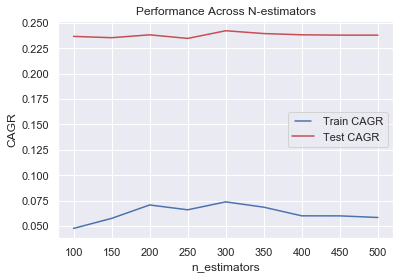

In [12]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train CAGR')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test CAGR')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('CAGR')
plt.xlabel('n_estimators')
plt.title('Performance Across N-estimators')
plt.show()

## n_estimator=300 was chose for optimal performance in both train and test set.

In [13]:
max_depths = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for depth in max_depths:
    rfcModel = RandomForestRegressor(max_depth=depth, n_estimators=300, random_state=42).fit(Xtrain, ytrain.flatten())
    Ypred = rfcModel.predict(Xtrain)
    
    retPred = np.nan * np.empty((flat_train, ))
    retPred[ixCleanTrain] = Ypred
    retPred = retPred.reshape(RetFutTrain.shape)

    def compare_nan_array(func, a, thresh):
        out = ~np.isnan(a)
        out[out] = func(a[out] , thresh)
        return out

    longs = pd.DataFrame(compare_nan_array(np.greater, retPred, 0).astype(int)).shift(1) #1 day later
    shorts = pd.DataFrame(compare_nan_array(np.less, retPred, 0).astype(int)).shift(1)

    longs.iloc[0] = 0
    shorts.iloc[0] = 0

    positions = np.zeros(retPred.shape)

    for h in range(holdingDays):
        long_lag = longs.shift(h)
        long_lag.fillna(value=0, inplace=True)
        long_lag = long_lag.to_numpy(dtype=bool)

        short_lag = shorts.shift(h)
        short_lag.fillna(value=0, inplace=True)
        short_lag = short_lag.to_numpy(dtype=bool)

        positions[long_lag] += 1
        positions[short_lag] -= 1

    dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1train.fillna(0).to_numpy()), axis=1)
    dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

    dailyRet = np.divide(dRetA, dRetB, out=np.zeros_like(dRetA), where=dRetB!=0)
    dailyRet[~np.isfinite(dailyRet)] = 0
    cumret = np.cumprod(1 + dailyRet) - 1


    cagr = (1 + cumret[-1]) ** (252 / trainSize) - 1
    train_results.append(cagr)
    maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
    ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
    print('max_depth=',depth,'\n',('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

    ##################################################################

    # Make real predictions on test (out-of-sample)
    Ypred = rfcModel.predict(Xtest)

    # print(('Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytest, Ypred))))

    retPred = np.nan * np.empty((RetFutTest.size, ))
    retPred[ixCleanTest] = Ypred
    retPred = retPred.reshape(RetFutTest.shape)

    longs = pd.DataFrame(compare_nan_array(np.greater, retPred, 0).astype(int)).shift(1) #1 day later
    shorts = pd.DataFrame(compare_nan_array(np.less, retPred, 0).astype(int)).shift(1)

    longs.iloc[0] = 0
    shorts.iloc[0] = 0

    positions = np.zeros(retPred.shape)

    for h in range(holdingDays):
        long_lag = longs.shift(h)
        long_lag.fillna(value=0, inplace=True)
        long_lag = long_lag.to_numpy(dtype=bool)

        short_lag = shorts.shift(h)
        short_lag.fillna(value=0, inplace=True)
        short_lag = short_lag.to_numpy(dtype=bool)

        positions[long_lag] += 1
        positions[short_lag] -= 1

    dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1test.fillna(0).to_numpy()), axis=1)
    dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

    dailyRet = np.divide(dRetA, dRetB, out=np.zeros_like(dRetA), where=dRetB!=0)
    dailyRet[~np.isfinite(dailyRet)] = 0
    cumret = np.cumprod(1 + dailyRet) - 1

    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()

    cagr = (1 + cumret[-1]) ** (252 / testSize) - 1
    test_results.append(cagr)
    maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
    ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
    print(('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

max_depth= 1.0 
 In-sample: CAGR=0.00210846 Sharpe ratio=0.16167 maxDD=-0.528619 maxDDD=685 Calmar ratio=0.00398862
Out-of-sample: CAGR=0.250752 Sharpe ratio=1.31507 maxDD=-0.216898 maxDDD=171 Calmar ratio=1.15609
max_depth= 2.0 
 In-sample: CAGR=0.00210846 Sharpe ratio=0.16167 maxDD=-0.528619 maxDDD=685 Calmar ratio=0.00398862
Out-of-sample: CAGR=0.250752 Sharpe ratio=1.31507 maxDD=-0.216898 maxDDD=171 Calmar ratio=1.15609
max_depth= 3.0 
 In-sample: CAGR=0.00721274 Sharpe ratio=0.177089 maxDD=-0.522747 maxDDD=673 Calmar ratio=0.0137978
Out-of-sample: CAGR=0.250204 Sharpe ratio=1.31362 maxDD=-0.216898 maxDDD=171 Calmar ratio=1.15356
max_depth= 4.0 
 In-sample: CAGR=0.0242416 Sharpe ratio=0.227871 maxDD=-0.501742 maxDDD=662 Calmar ratio=0.0483149
Out-of-sample: CAGR=0.244486 Sharpe ratio=1.33386 maxDD=-0.209944 maxDDD=171 Calmar ratio=1.16453
max_depth= 5.0 
 In-sample: CAGR=0.0738231 Sharpe ratio=0.397353 maxDD=-0.439698 maxDDD=531 Calmar ratio=0.167895
Out-of-sample: CAGR=0.242307 Sh

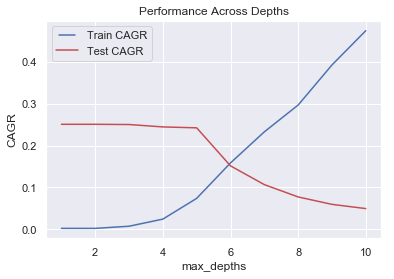

In [14]:
line1, = plt.plot(max_depths, train_results, 'b', label='Train CAGR')
line2, = plt.plot(max_depths, test_results, 'r', label='Test CAGR')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('CAGR')
plt.xlabel('max_depths')
plt.title('Performance Across Depths')
plt.show()

In [15]:
RFregModel = RandomForestRegressor(max_depth=5, n_estimators=300, random_state=42).fit(Xtrain, ytrain.flatten())


# Make "predictions" based on model on training set, reshape back to original matrix dimensions
Ypred_train = RFregModel.predict(Xtrain)
Ypred_test = RFregModel.predict(Xtest)

print(('Train set Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytrain, Ypred_train))))
print(('Test set Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytest, Ypred_test))))
from sklearn.metrics import r2_score
print(('Train set R-squared = {}').format(r2_score(ytrain, Ypred_train)))
print(('Test set R-squared = {}').format(r2_score(ytest, Ypred_test)))

Train set Root Mean Squared Error = 0.1089
Test set Root Mean Squared Error = 0.0695
Train set R-squared = 0.13457609416170813
Test set R-squared = -0.03519610178679744


# R2 of test set has a negative value

In-sample: CAGR=0.0738231 Sharpe ratio=0.397353 maxDD=-0.439698 maxDDD=531 Calmar ratio=0.167895
Out-of-sample: CAGR=0.242307 Sharpe ratio=1.37122 maxDD=-0.204809 maxDDD=171 Calmar ratio=1.18309


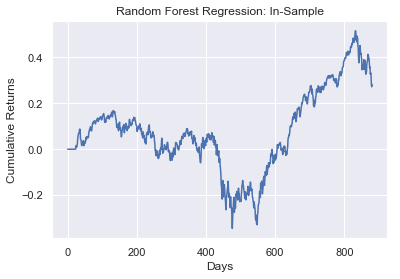

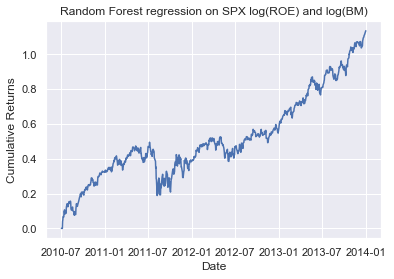

'\nIn-sample: CAGR=0.0495108 Sharpe ratio=0.334931 maxDD=-0.323853 maxDDD=447 Calmar ratio=0.152881\nOut-of-sample: CAGR=0.10437 Sharpe ratio=0.982639 maxDD=-0.139648 maxDDD=413 Calmar ratio=0.747375\n'

In [16]:
# Make "predictions" based on model on training set, reshape back to original matrix dimensions
Ypred = RFregModel.predict(Xtrain)

retPred = np.nan * np.empty((flat_train, ))
retPred[ixCleanTrain] = Ypred
retPred = retPred.reshape(RetFutTrain.shape)

def compare_nan_array(func, a, thresh):
    out = ~np.isnan(a)
    out[out] = func(a[out] , thresh)
    return out

longs = pd.DataFrame(compare_nan_array(np.greater, retPred, 0).astype(int)).shift(1) #1 day later
shorts = pd.DataFrame(compare_nan_array(np.less, retPred, 0).astype(int)).shift(1)

longs.iloc[0] = 0
shorts.iloc[0] = 0

positions = np.zeros(retPred.shape)

for h in range(holdingDays):
    long_lag = longs.shift(h)
    long_lag.fillna(value=0, inplace=True)
    long_lag = long_lag.to_numpy(dtype=bool)
    
    short_lag = shorts.shift(h)
    short_lag.fillna(value=0, inplace=True)
    short_lag = short_lag.to_numpy(dtype=bool)
    
    positions[long_lag] += 1
    positions[short_lag] -= 1

dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1train.fillna(0).to_numpy()), axis=1)
dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

dailyRet = np.divide(dRetA, dRetB, out=np.zeros_like(dRetA), where=dRetB!=0)
dailyRet[~np.isfinite(dailyRet)] = 0
cumret = np.cumprod(1 + dailyRet) - 1

plt.figure(1)
plt.plot(range(trainSize), cumret)
plt.title('Random Forest Regression: In-Sample')
plt.ylabel('Cumulative Returns')
plt.xlabel('Days')

cagr = (1 + cumret[-1]) ** (252 / trainSize) - 1
maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
print(('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

##################################################################

# Make real predictions on test (out-of-sample)
Ypred = RFregModel.predict(Xtest)

# print(('Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytest, Ypred))))

retPred = np.nan * np.empty((RetFutTest.size, ))
retPred[ixCleanTest] = Ypred
retPred = retPred.reshape(RetFutTest.shape)

longs = pd.DataFrame(compare_nan_array(np.greater, retPred, 0).astype(int)).shift(1) #1 day later
shorts = pd.DataFrame(compare_nan_array(np.less, retPred, 0).astype(int)).shift(1)

longs.iloc[0] = 0
shorts.iloc[0] = 0

positions = np.zeros(retPred.shape)

for h in range(holdingDays):
    long_lag = longs.shift(h)
    long_lag.fillna(value=0, inplace=True)
    long_lag = long_lag.to_numpy(dtype=bool)
    
    short_lag = shorts.shift(h)
    short_lag.fillna(value=0, inplace=True)
    short_lag = short_lag.to_numpy(dtype=bool)
    
    positions[long_lag] += 1
    positions[short_lag] -= 1

dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1test.fillna(0).to_numpy()), axis=1)
dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

dailyRet = np.divide(dRetA, dRetB, out=np.zeros_like(dRetA), where=dRetB!=0)
dailyRet[~np.isfinite(dailyRet)] = 0
cumret = np.cumprod(1 + dailyRet) - 1

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(2)
plt.plot(datesTest, cumret)
plt.title('Random Forest regression on SPX log(ROE) and log(BM)')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')

cagr = (1 + cumret[-1]) ** (252 / testSize) - 1
maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
print(('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

plt.show() 


"""
In-sample: CAGR=0.0495108 Sharpe ratio=0.334931 maxDD=-0.323853 maxDDD=447 Calmar ratio=0.152881
Out-of-sample: CAGR=0.10437 Sharpe ratio=0.982639 maxDD=-0.139648 maxDDD=413 Calmar ratio=0.747375
"""

## It seems the train set has underfit a bit, because it perform a lot better in test set than train set. Let's try the parameter setting that will balance the two results.

In [17]:
RFregModel = RandomForestRegressor(max_depth=6, n_estimators=300, random_state=42).fit(Xtrain, ytrain.flatten())


# Make "predictions" based on model on training set, reshape back to original matrix dimensions
Ypred_train = RFregModel.predict(Xtrain)
Ypred_test = RFregModel.predict(Xtest)

print(('Train set Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytrain, Ypred_train))))
print(('Test set Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytest, Ypred_test))))
from sklearn.metrics import r2_score
print(('Train set R-squared = {}').format(r2_score(ytrain, Ypred_train)))
print(('Test set R-squared = {}').format(r2_score(ytest, Ypred_test)))

Train set Root Mean Squared Error = 0.1072
Test set Root Mean Squared Error = 0.0696
Train set R-squared = 0.16210057784585863
Test set R-squared = -0.03857809581900851


# R2 of test set has a negative value

In-sample: CAGR=0.15848 Sharpe ratio=0.847873 maxDD=-0.237785 maxDDD=210 Calmar ratio=0.666482
Out-of-sample: CAGR=0.15143 Sharpe ratio=1.31301 maxDD=-0.127081 maxDDD=118 Calmar ratio=1.1916


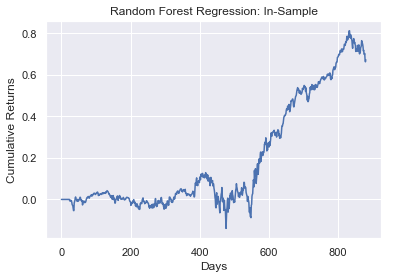

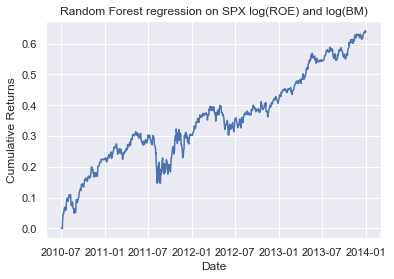

'\nIn-sample: CAGR=0.0495108 Sharpe ratio=0.334931 maxDD=-0.323853 maxDDD=447 Calmar ratio=0.152881\nOut-of-sample: CAGR=0.10437 Sharpe ratio=0.982639 maxDD=-0.139648 maxDDD=413 Calmar ratio=0.747375\n'

In [18]:
# Make "predictions" based on model on training set, reshape back to original matrix dimensions
Ypred = RFregModel.predict(Xtrain)

retPred = np.nan * np.empty((flat_train, ))
retPred[ixCleanTrain] = Ypred
retPred = retPred.reshape(RetFutTrain.shape)

def compare_nan_array(func, a, thresh):
    out = ~np.isnan(a)
    out[out] = func(a[out] , thresh)
    return out

longs = pd.DataFrame(compare_nan_array(np.greater, retPred, 0).astype(int)).shift(1) #1 day later
shorts = pd.DataFrame(compare_nan_array(np.less, retPred, 0).astype(int)).shift(1)

longs.iloc[0] = 0
shorts.iloc[0] = 0

positions = np.zeros(retPred.shape)

for h in range(holdingDays):
    long_lag = longs.shift(h)
    long_lag.fillna(value=0, inplace=True)
    long_lag = long_lag.to_numpy(dtype=bool)
    
    short_lag = shorts.shift(h)
    short_lag.fillna(value=0, inplace=True)
    short_lag = short_lag.to_numpy(dtype=bool)
    
    positions[long_lag] += 1
    positions[short_lag] -= 1

dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1train.fillna(0).to_numpy()), axis=1)
dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

dailyRet = np.divide(dRetA, dRetB, out=np.zeros_like(dRetA), where=dRetB!=0)
dailyRet[~np.isfinite(dailyRet)] = 0
cumret = np.cumprod(1 + dailyRet) - 1

plt.figure(1)
plt.plot(range(trainSize), cumret)
plt.title('Random Forest Regression: In-Sample')
plt.ylabel('Cumulative Returns')
plt.xlabel('Days')

cagr = (1 + cumret[-1]) ** (252 / trainSize) - 1
maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
print(('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

##################################################################

# Make real predictions on test (out-of-sample)
Ypred = RFregModel.predict(Xtest)

# print(('Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytest, Ypred))))

retPred = np.nan * np.empty((RetFutTest.size, ))
retPred[ixCleanTest] = Ypred
retPred = retPred.reshape(RetFutTest.shape)

longs = pd.DataFrame(compare_nan_array(np.greater, retPred, 0).astype(int)).shift(1) #1 day later
shorts = pd.DataFrame(compare_nan_array(np.less, retPred, 0).astype(int)).shift(1)

longs.iloc[0] = 0
shorts.iloc[0] = 0

positions = np.zeros(retPred.shape)

for h in range(holdingDays):
    long_lag = longs.shift(h)
    long_lag.fillna(value=0, inplace=True)
    long_lag = long_lag.to_numpy(dtype=bool)
    
    short_lag = shorts.shift(h)
    short_lag.fillna(value=0, inplace=True)
    short_lag = short_lag.to_numpy(dtype=bool)
    
    positions[long_lag] += 1
    positions[short_lag] -= 1

dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1test.fillna(0).to_numpy()), axis=1)
dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

dailyRet = np.divide(dRetA, dRetB, out=np.zeros_like(dRetA), where=dRetB!=0)
dailyRet[~np.isfinite(dailyRet)] = 0
cumret = np.cumprod(1 + dailyRet) - 1

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(2)
plt.plot(datesTest, cumret)
plt.title('Random Forest regression on SPX log(ROE) and log(BM)')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')

cagr = (1 + cumret[-1]) ** (252 / testSize) - 1
maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
print(('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

plt.show() 


"""
In-sample: CAGR=0.0495108 Sharpe ratio=0.334931 maxDD=-0.323853 maxDDD=447 Calmar ratio=0.152881
Out-of-sample: CAGR=0.10437 Sharpe ratio=0.982639 maxDD=-0.139648 maxDDD=413 Calmar ratio=0.747375
"""